In [1]:
!python --version

Python 3.9.18


In [2]:
# !pip install segmentation-models
# !pip install tensorflow
# !pip install keras
# !pip install tensorflow-estimator

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


# **Segmentation of Iris**

**Special Requirements**

In [3]:
# !pip install livelossplot
# !pip install h5py==2.10.0

**Mounting the Drive**


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

**Importing Required Libraries**

In [5]:
%matplotlib inline

In [6]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted

In [7]:
# !pip install -U segmentation-models

In [8]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow
# !pip install -q keras
# !pip install -q tensorflow-estimator

## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

**Storing & Creating Training sets from images from mounted drive**

In [9]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128
OGX = 3000
OGY = 1700

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("image"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))) :
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)   #cv2.IMREAD_COLOR
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing


train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("mask"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        #print(mask_path)
        mask = cv2.imread(mask_path, 0)   #,0
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR) #
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks)


In [10]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
# Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


**Define Model**

In [11]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

**Model Fitting (One Time)**

In [12]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


In [13]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(
   x_train,
   y_train,
   batch_size=32,
   epochs=10, #was 200 for checking change to 2
   verbose=1,
   validation_data=(x_val, y_val),
)

#accuracy = model.evaluate(x_val, y_val)


Epoch 1/10
3/3 [==============================] - 22s 3s/step - loss: 5149.1685 - accuracy: 0.5945 - val_loss: 5215.7090 - val_accuracy: 0.0221
Epoch 2/10
3/3 [==============================] - 10s 3s/step - loss: 5136.5928 - accuracy: 0.6497 - val_loss: 5214.6616 - val_accuracy: 4.5437e-04
Epoch 3/10
3/3 [==============================] - 10s 3s/step - loss: 5131.2266 - accuracy: 0.6552 - val_loss: 5214.6895 - val_accuracy: 7.1208e-05
Epoch 4/10
3/3 [==============================] - 10s 3s/step - loss: 5129.4165 - accuracy: 0.6443 - val_loss: 5214.6958 - val_accuracy: 8.8162e-05
Epoch 5/10
3/3 [==============================] - 10s 3s/step - loss: 5129.0527 - accuracy: 0.6600 - val_loss: 5214.6973 - val_accuracy: 6.7817e-05
Epoch 6/10
3/3 [==============================] - 10s 3s/step - loss: 5128.9087 - accuracy: 0.6805 - val_loss: 5214.6978 - val_accuracy: 6.7817e-05
Epoch 7/10
3/3 [==============================] - 10s 3s/step - loss: 5128.8853 - accuracy: 0.6983 - val_loss: 5214.

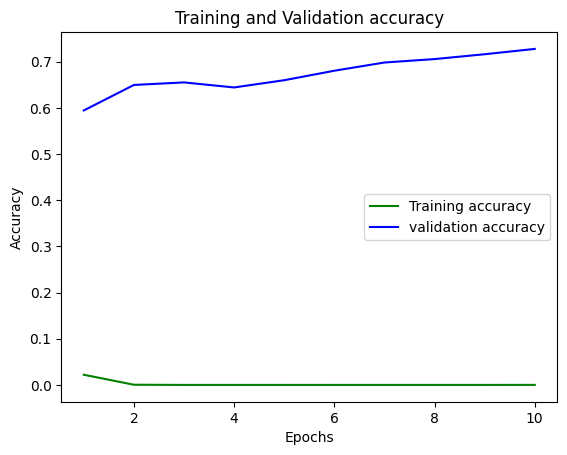

In [14]:
# EPOCHS VS ACCURACY
acc_train = history.history['val_accuracy']
acc_val = history.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Saving the Model**

In [15]:
model.save('Iria_90.h5')

C:\Users\yashs\anaconda3\envs\project39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Testing Area**

In [10]:
from tensorflow import keras
model = keras.models.load_model('Iria_90.h5', compile=False)

**Upload & Read Image**

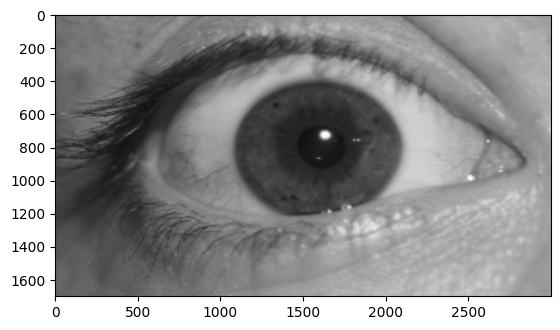

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128
OGX = 3000
OGY = 1700
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('4.png', cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_image = test_img
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))


test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

test_image = cv2.resize(test_image, (OGX, OGY))

plt.imshow(test_image)
# plt.imsave('/content/drive/MyDrive/iris/og.jpg', test_image, cmap='gray')


**Segmentate Mask**

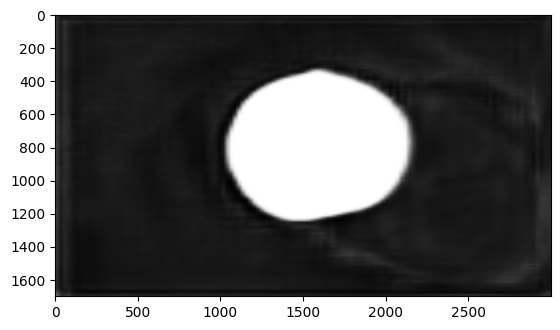

In [28]:
#View and Save segmented image
prediction_image = prediction.reshape((SIZE_X,SIZE_Y))

prediction_image = cv2.resize(prediction_image, (OGX, OGY))
plt.imshow(prediction_image, cmap='gray')
plt.imsave('segmented.jpg', prediction_image, cmap='gray')

import cv2
import numpy as np

# Resize the image to 256x265
# Ensure the image size is 256x256
desired_size = (256, 256)
prediction_image = cv2.resize(prediction_image, desired_size)

# Calculate the position for the window to be in the middle of the screen
screen_width = 1366  # Change this to your screen's width
screen_height = 768  # Change this to your screen's height
x_position = (screen_width - desired_size[0]) // 2
y_position = (screen_height - desired_size[1]) // 2

# Create a window and display the image
cv2.namedWindow('Segmented Image', cv2.WINDOW_NORMAL)
cv2.moveWindow('Segmented Image', x_position, y_position)
cv2.imshow('Segmented Image', prediction_image)

# Wait for a key event and close the window when a key is pressed
cv2.waitKey(0)
cv2.destroyAllWindows()

**Test Image + Segmentate Mask**

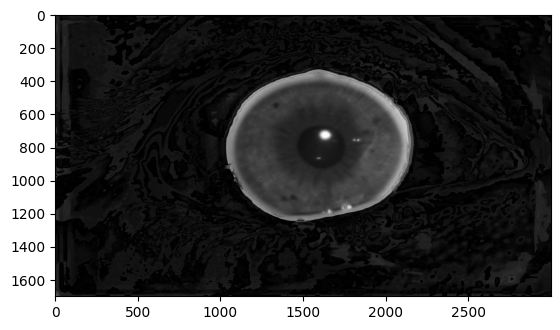

In [29]:
imgg = cv2.imread('segmented.jpg')

#imgg2 = cv2.resize(imgg2, (SIZE_Y, SIZE_X))
imgg = cv2.resize(imgg, (OGX, OGY))
imgg =  cv2.cvtColor(imgg, cv2.COLOR_RGB2BGR)
annd = cv2.bitwise_and(imgg, test_image)

plt.imshow(annd, cmap='gray')

# plt.imsave('/content/drive/MyDrive/iris/segmentedfinal.jpg', annd, cmap='gray')



import cv2
import numpy as np

# Resize the image to 256x265
# Ensure the image size is 256x256
desired_size = (256, 256)
prediction_image = cv2.resize(annd, desired_size)

# Calculate the position for the window to be in the middle of the screen
screen_width = 1366  # Change this to your screen's width
screen_height = 768  # Change this to your screen's height
x_position = (screen_width - desired_size[0]) // 2
y_position = (screen_height - desired_size[1]) // 2

# Create a window and display the image
cv2.namedWindow('Segmented Image', cv2.WINDOW_NORMAL)
cv2.moveWindow('Segmented Image', x_position, y_position)
cv2.imshow('Segmented Image', prediction_image)

# Wait for a key event and close the window when a key is pressed
cv2.waitKey(0)
cv2.destroyAllWindows()
